## GMM Baseline
 - 이 노트북은 GMM(Gaussian Mixture Models)을 활용한 딥페이크 탐지 베이스라인 예시입니다.
 - 베이스라인은 Jupyter Notebook이며 프로젝트 진행 시 Python 스크립트 환경에서 작성하셔도 됩니다.

In [15]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np

### 1. 데이터 전처리
 - GMM에 입력하기 위해 오디오 데이터를 특징 벡터로 변환합니다.  
 - 여기서는 MFCC, Delta, Delta-Delta 특징을 사용합니다.

In [16]:
# 훈련 데이터 metadata 경로 지정
train_metadata_path = '../2501ml_data/label/train_label.txt'

# 훈련 데이터 경로 지정
train_data_path = '../2501ml_data/train'

# 훈련 데이터의 음성 파일과 레이블을 저장할 리스트 초기화
train_x = []
train_y = []
with open(train_metadata_path, 'r') as f:
    # 각 줄을 읽어와서 음성 파일 경로와 레이블을 분리
    for line in f:
        # 각 줄은 화자, 파일 이름, 라벨로 구성되어 있음
        spk, file_name, _, _, label = line.strip().split(' ')
        
        # wav 경로
        wav_path = os.path.join(train_data_path, file_name)

        # MFCC, MFCC delta, MFCC delta-delta 추출
        y, sr = librosa.load(wav_path, sr=16000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

        # MFCC, MFCC delta, MFCC delta-delta를 하나의 배열로 결합
        mfcc_combined = np.concatenate((mfcc, mfcc_delta, mfcc_delta2), axis=0)
        # 각 특징의 계수별 평균 계산
        mfcc_mean = np.mean(mfcc_combined, axis=1)

        # 훈련 데이터는 X에 저장
        train_x.append(mfcc_mean)

        # 라벨은 Y에 저장
        train_y.append(label)

In [17]:
print("훈련 데이터의 개수:", len(train_x))
print("훈련 데이터 X의 shape:", train_x[0].shape)

훈련 데이터의 개수: 4000
훈련 데이터 X의 shape: (60,)


In [18]:
# 테스트 데이터 metadata 경로 지정
test_metadata_path = '../2501ml_data/label/test_label.txt'

# 테스트 데이터 경로 지정
test_data_path = '../2501ml_data/test'

# 테스트 데이터의 음성 파일과 레이블을 저장할 리스트 초기화
test_file_names = []
test_x = []
test_y = []
with open(test_metadata_path, 'r') as f:
    # 각 줄을 읽어와서 음성 파일 경로와 레이블을 분리
    for line in f:
        # 각 줄은 화자, 파일 이름, 라벨로 구성되어 있음
        spk, file_name, _, _, label = line.strip().split(' ')
        
        # wav 경로
        wav_path = os.path.join(test_data_path, file_name)

        # MFCC, MFCC delta, MFCC delta-delta 추출
        y, sr = librosa.load(wav_path, sr=16000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

        # MFCC, MFCC delta, MFCC delta-delta를 하나의 배열로 결합
        mfcc_combined = np.concatenate((mfcc, mfcc_delta, mfcc_delta2), axis=0)
        # 각 특징의 계수별 평균 계산
        mfcc_mean = np.mean(mfcc_combined, axis=1)

        # 테스트 데이터는 X에 저장
        test_x.append(mfcc_mean)

        # 라벨은 Y에 저장
        test_y.append(label)

        # 테스트 데이터 파일 이름 저장
        test_file_names.append(file_name)

In [19]:
print("테스트 데이터의 개수:", len(test_x))
print("테스트 데이터 X의 shape:", test_x[0].shape)

테스트 데이터의 개수: 2000
테스트 데이터 X의 shape: (60,)


### 2. GMM 훈련
 - GMM 객체를 생성합니다.
 - 훈련 데이터로 학습하고 테스트 데이터를 통해 정확도를 계산합니다.

In [20]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [21]:
# 리스트를 numpy 배열로 변환
train_x = np.array(train_x)
train_y = np.array(train_y)

# 두 클래스의 데이터를 분리
real_x = train_x[train_y == 'Real']
fake_x = train_x[train_y == 'Fake']

In [22]:
# 각 클래스별 GMM 모델 학습
gmm_real = GaussianMixture(n_components=3,
                           random_state=42)
gmm_fake = GaussianMixture(n_components=3,
                           random_state=42)

gmm_real.fit(real_x)
gmm_fake.fit(fake_x)

GaussianMixture(n_components=3, random_state=42)

In [23]:
# 테스트 데이터를 numpy 배열로 변환
test_x = np.array(test_x)
test_y = np.array(test_y)

# 각 샘플에 대해 두 GMM의 log-likelihood 계산
ll_real = gmm_real.score_samples(test_x)
ll_fake = gmm_fake.score_samples(test_x)

In [24]:
# 로그 확률이 더 큰 클래스로 예측
y_pred = ['Real' if r > f else 'Fake' for r, f in zip(ll_real, ll_fake)]

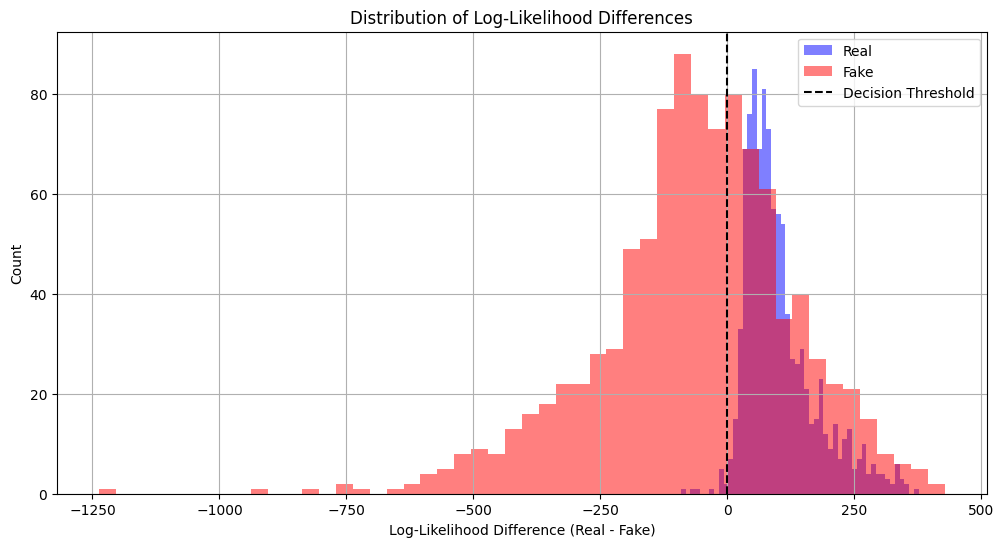

In [25]:
# Log-likelihood 차이 계산 (양수면 Real, 음수면 Fake로 분류)
ll_diff = ll_real - ll_fake

# 실제 레이블에 따라 색상 구분하여 히스토그램 그리기
plt.figure(figsize=(12, 6))
for label, color in zip(['Real', 'Fake'], ['blue', 'red']):
    idx = test_y == label
    plt.hist(ll_diff[idx], bins=50, alpha=0.5, color=color, label=label)

plt.axvline(x=0, color='k', linestyle='--', label='Decision Threshold')
plt.xlabel('Log-Likelihood Difference (Real - Fake)')
plt.ylabel('Count')
plt.title('Distribution of Log-Likelihood Differences')
plt.legend()
plt.grid(True)
plt.show()

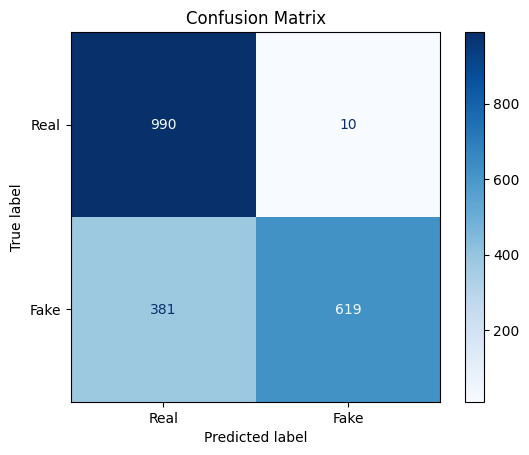

In [26]:
cm = confusion_matrix(test_y, y_pred, labels=['Real', 'Fake'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### 3. 예측 결과 파일 작성

In [27]:
with open('./team_test_result.txt', 'w') as f:
    for i in range(len(y_pred)):
        f.write(f"{test_file_names[i]} {y_pred[i]}\n")

In [28]:
!perl ../eval.pl ./team_test_result.txt ../2501ml_data/label/test_label.txt

============ Results Analysis ===========
Test: ./team_test_result.txt
True: ../2501ml_data/label/test_label.txt
Accuracy: 80.45%
Hit: 1609, Total: 2000
